In [1]:
# import stuff. 
import pandas as pd 
import os 
import random
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns 
from os import listdir
from os.path import isfile, join
import re 
import gensim 
import pyLDAvis
import pyLDAvis.gensim
import warnings
from wordcloud import WordCloud
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# pickle load function
def pickle_load(filename, folder): 
    with open(f"../data/{folder}/{filename}.pkl", "rb") as f:
        file = pkl.load(f) 
    return file

In [6]:
## load raw data. 
os.getcwd()
comments = pickle_load("comments_collected", "preprocessed")
submissions = pickle_load("submissions_collected", "preprocessed")


In [7]:
## find number of unique authors (across). 
unique_authors = len(set(comments.author.values).intersection(set(submissions.author.values)))

## unique number of comments / submissions. 
unique_texts = len(set(comments.body.values)) + len(set(submissions.selftext.values))

# rough and uncut (as they say in the business). 
print(f"unique authors: {unique_authors}")
print(f"unique texts: {unique_texts}")


unique authors: 17563
unique texts: 439118


In [58]:
# ensemble approach: 
## 1. not really sure that it is actually ensemble. 
## 2. there is a link to a source for the automatic part. 
## 3. no real sources. 

In [8]:
# list of nltk stopwords: take your pick :) 
import nltk 
nltk.corpus.stopwords.words("english")

# list of our own stopwords. 
our_stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and",
                "any", "are", "as", "at", "be", "because", "been", "before", "being", "below",
                "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down",
                "during", "each", "few", "for", "from", "further", "had", "has", "have",
                "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers",
                "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm",
                "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me",
                "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other",
                "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd",
                "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the",
                "their", "theirs", "them", "themselves", "then", "there", "there's", "these",
                "they", "they'd", "they'll", "they're", "they've", "this", "those", "through",
                "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll",
                "we're", "we've", "were", "what", "what's", "when", "when's", "where",
                "where's", "which", "while", "who", "who's", "whom", "why", "why's",
                "with", "would", "you", "you'd", "you'll", "you're", "you've", "your",
                "yours", "yourself", "yourselves"]

In [13]:
# Question: one winner (between trees / threads)?
## read corpus and dictionary 
thread_dct = pickle_load("H1_thread_dct", "modeling")
thread_corpus = pickle_load("H1_thread_corpus", "modeling")
tree_dct = pickle_load("H1_tree_dct", "modeling")
tree_corpus = pickle_load("H1_thread_corpus", "modeling")

## import models ##
thread = pickle_load("H1_thread_models_b0.1_b1", "models")
tree = pickle_load("H1_tree_models", "models")

## select specific models screened prior ##
thread = thread['a0.01_b0.1_k30']
tree = tree['a0.01_b0.1_k30']

In [14]:
## There is some issue with threads. 
## not local issue (i.e. same for k = 35).
## better topic separation in trees?
## depends on what our "master metric" is. 
pyLDAvis.enable_notebook()
thread_pyLDA = pyLDAvis.gensim.prepare(thread, thread_corpus, thread_dct, sort_topics = False) ## so that it corresponds to gensim
pyLDAvis.display(thread_pyLDA)

In [15]:
## then visualize tree 
tree_pyLDA = pyLDAvis.gensim.prepare(tree, tree_corpus, tree_dct, sort_topics = False)
pyLDAvis.display(tree_pyLDA)

In [ ]:
## more for the tree / threads split?

In [12]:
# Q: number for threads: 52115 as you provide? 
# again: depends on where in the analysis.
# this is after preprocessing (as the other numbers we provide). 

In [ ]:
# Q: meaning for figure.
# A: what do you mean?

In [ ]:
# Q: do we have this for threads & submission. 
# A: threads above, submission below. 

In [22]:
# submission pyLDAvis
# load stuff
sub_mod = pickle_load("H2_submissions_b0.1_a0.01", "models")
sub_corpus = pickle_load("H2_submissions_corpus", "modeling")
sub_dct = pickle_load("H2_submissions_dct", "modeling")
sub = sub_mod['a0.01_b0.1_k30']

# run pyLDAvis
# same problem: 1 good dimension (as for threads). 
sub_pyLDA = pyLDAvis.gensim.prepare(sub, sub_corpus, sub_dct, sort_topics = False)
pyLDAvis.display(sub_pyLDA)

In [27]:
# Q: overall used words.
# A1: atomic unit? 
# A2: useful words or just all words?
# function to plot most frequent terms (thanks Morena). 
def freq_words(x, ascending=False, terms = 30):
    """
    Plot word frequency
    Input: pd.Series, direction, num. of words
    """
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top most frequent words
    d = words_df.sort_values("count", ascending=ascending)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d[:terms], x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.title("Words Frequency")
    plt.xticks(rotation=45)
    plt.show()
    
# more Morena functions (thanks :D :D )
def vocabulary_freq_words(dictionary, ascending=False, terms = 30):
    """
    Plot word frequency by the number of documents that contains it
    Input: gensim dictionary, direction, num. of words
    """
    
    dict_id2token = {id_:tok_ for (tok_, id_) in dictionary.token2id.items()}
    dict_token2freq = {dict_id2token[k]:v for (k,v) in dictionary.dfs.items()}

    words_df = pd.DataFrame.from_dict(dict_token2freq, orient="index", columns=["count"])

    # selecting top most frequent words
    d = words_df.sort_values("count", ascending=ascending).reset_index()
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d[:terms], x= "index", y = "count")
    ax.set(ylabel = 'Count')
    plt.title("Words Frequency")
    plt.xticks(rotation=45)
    plt.show()

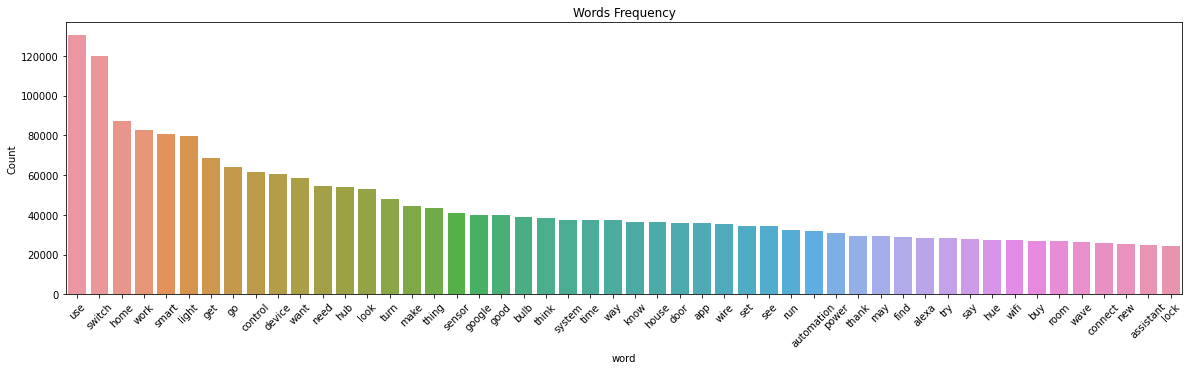

In [26]:
# after preprocessing: 
all_data = pickle_load("concat_data2", "preprocessed")

# all words: 
freq_words(all_data["clean_text"], False, 50) #descending & 50 words (after basic preprocessing). 

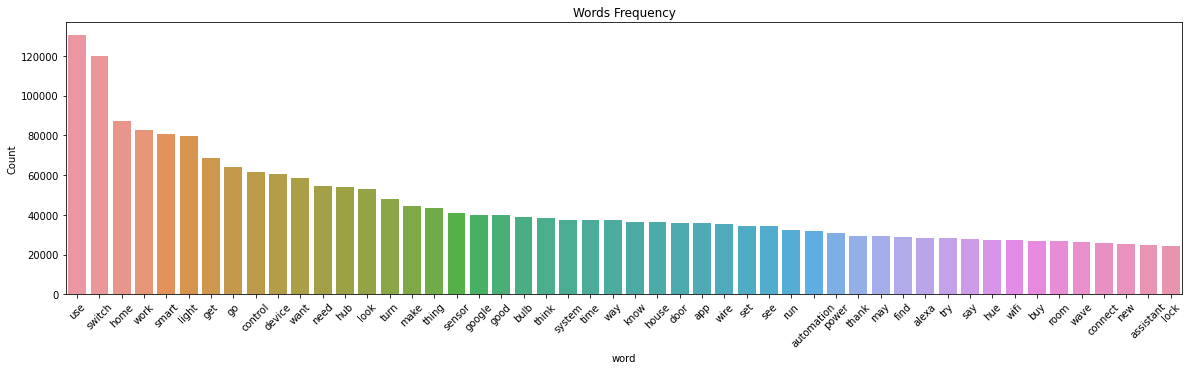

In [28]:
# only threads (basically the same).. 
thread = pickle_load("H1_thread", "clean")
freq_words(thread["clean_text"], False, 50)

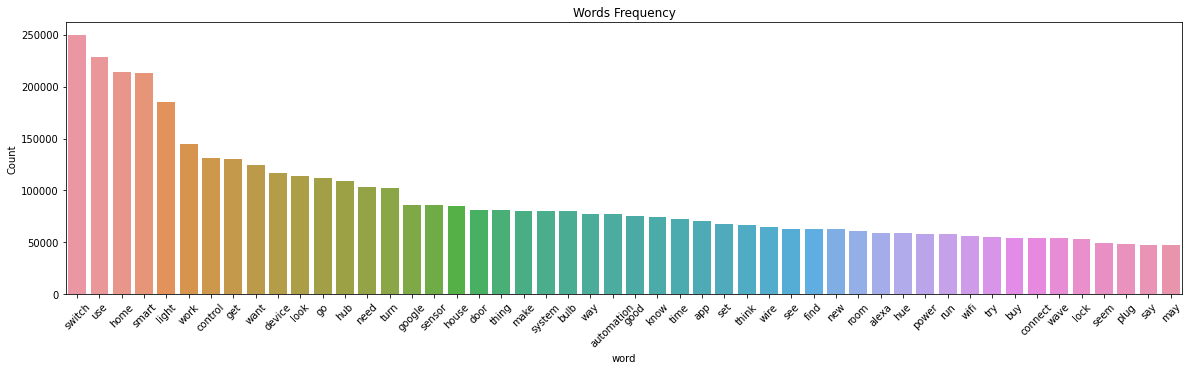

In [29]:
# only trees (qualitatively the same)
tree = pickle_load("H1_tree", "clean")
freq_words(tree["clean_text"], False, 50)

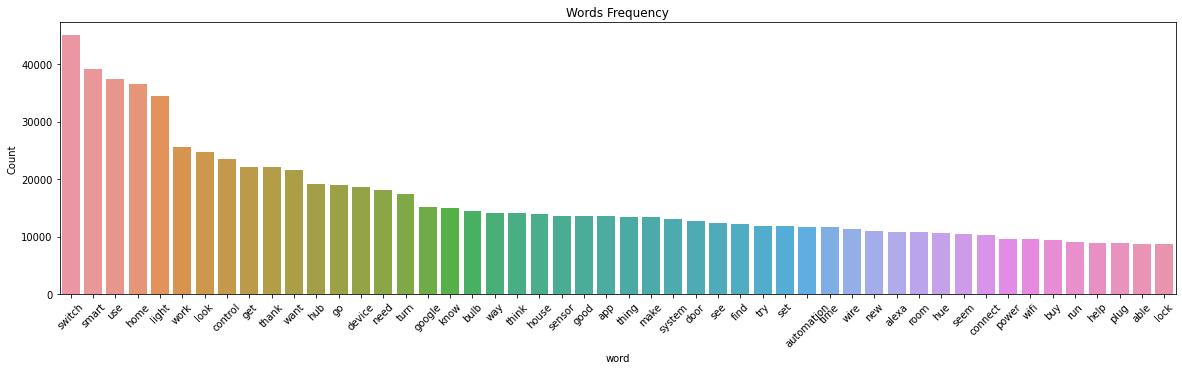

In [30]:
# only submissions
submissions = pickle_load("H2_submissions", "clean")
freq_words(submissions["clean_text"], False, 50)

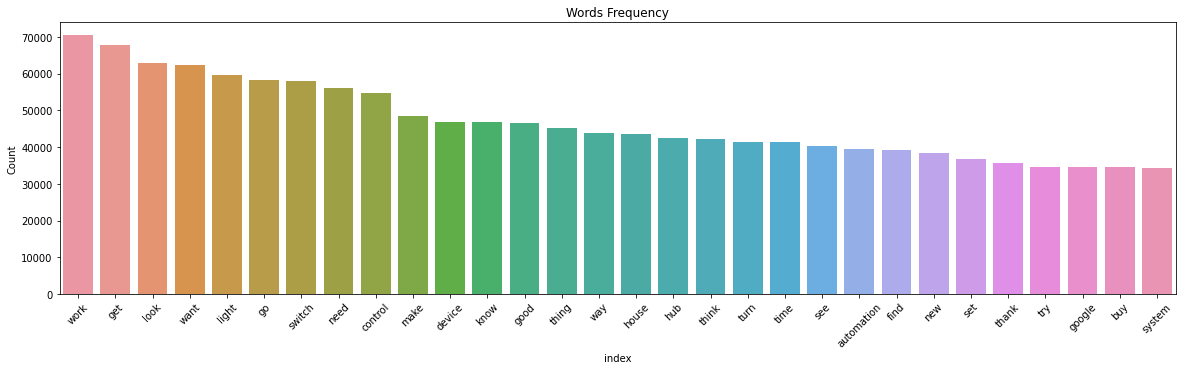

In [31]:
# what the model actually sees (dictionary): 
#NLP_vis.vocabulary_freq_words(, False, 30)
vocabulary_freq_words(tree_dct)

In [ ]:
# Q: super big table. 
# A: sorry, what do you mean? (see picture). 

In [3]:
# Mikkel Werling signature. 
def query_topic(data, sub_size, query, topic = False):
    '''
    Queries a dataframe and gives a subset of sub_size length.
    This query contains both the topic and a query string. 
    Alternatively, setting topic = False only queries the dataframe
    and returns the sorted dataframe.
    '''
    if topic:
        data = data[(data["Text"].str.contains(query)) & (data["Dominant_Topic"] == topic)]
    else:
        data = data[data["Text"].str.contains(query)]
    return data.sort_values("Topic_Perc_Contribution", ascending=False).head(sub_size)

In [5]:
# Q: trust & privacy (manual checks). 
# A: yes - we thought that was in appendix :) 
with open(f"../data/modeling/topic_dfs/topic_dfsH2_submissions_30.pkl", "rb") as f: 
    data = pkl.load(f)

privacy = query_topic(data, 10, "privacy")
security = query_topic(data, 10, "security")
trust = query_topic(data, 10, "trust")


In [12]:
for i, e in enumerate(privacy["Text"].values):
    print(f"{i}: \n {e}")

0: 
 Best security system for a vacation rental? Please let me know if I should repost to Homedefense/Homesecurity

Looking for a security system (ideally DIY with cheap monitoring) for my mom's vacation rental that she rents via HomeAway/VRBO. 

Ideally I need:

1.- 2 Outdoor cameras (front yard + rear driveway)

2.- Smart locks with codes that can be changed online/via app for each guest and that are either inside the alarm system or sufficiently integrated so that the alarm will never go off when guests enter/exit the house. I need possibilities to track entrances/exits of different users in order to keep track of maids, maintenance guy, and 
check in/out times.

3.- No indoor cameras (privacy concerns for guests) 


The home to secure is a large two story home with many ground floor entries, to wit:

1.- 4 normal doors

2.- 2 double french doors

3.- 1 2 car garage door 

4.- 8 large windows


For me the priority is to be able to have the exterior cameras and the alarm system when 

In [13]:
for i, e in enumerate(security["Text"].values):
    print(f"{i}: \n {e}")

0: 
 Looking for video doorbell as well as security camera options for parent's house My mom and step dad (60s) have just moved to a new house. They are in a very safe neighborhood, but their front door has no peephole and no windows to look out and see who is at the door. Normally I wouldn't be concerned, but my step dad's mom (80s) has gone completely r/JustNoMIL with threats against my mom and calling my step dad non stop to just yell at him about nonsense. She lives close to their house and, while hey son wants nothing to do with her, it's totally within her realm to show up unannounced. I just want them to be able to know who is at the door, but I'm also interested in getting them some security cameras for the back screened in porch and a few other windows. I'm not super tech savvy, but with instruction and YouTube I can figure most things out so I'm wondering what's my best option for something they will be able to use easily and will keep them safe.
1: 
 Question about home secu

In [14]:
for i, e in enumerate(trust["Text"].values):
    print(f"{i}: \n {e}")

0: 
 Anyone has the ECOVACS DEEBOT SLIM2? There is a sale in Amazon.ca today for this Robotic Vacuum Cleaner but I can't find any reviews on it other than the ones on Amazon (which I don't trust anymore). Anyone has any experience with it? Thanks
1: 
 Anyone trust Kaspersky as their IoT backbone? 
2: 
 Add old home alarm system to home automation system. I have a Honeywell alarm system that I already have a set of key-fobs with which I can arm or disarm the system.  What I would like is a z-wave(or other) controller that I could replace the key-fobs system with that could connect to a home automation system?  Is there an add-on module that might do this or an updated key pad?  

The key-fobs can go, have not used them in years, they cannot be trusted in my pocket.
 
3: 
 Tuya convert captive portal Back in December I attempted to use tuya convert to put tasmota on a few devices. I was using Rasbian stretch on a raspberry pi 3. I updated tuya convert and stretch prior to attempting the 

*Q: Where is this submission model. Topic 2 and 29 are not the same like figure 5 right?*

Correct! The distance metric looks crazy in submissions, but Fig. 7 shows what the main contributing words for the topics are 